**1. Loading and Pre-processing of Data**


=== Processing Fengyun-2F.csv ===
Missing daily BEFORE interpolation: 430
Any missing AFTER interpolation? False
ADF Statistic: -17.8567 | p-value: 3.065e-30
Stationarity: ✅ Yes (p<0.05)
Time step distribution (top 5):
timestamp
1 days    3413
Name: count, dtype: int64


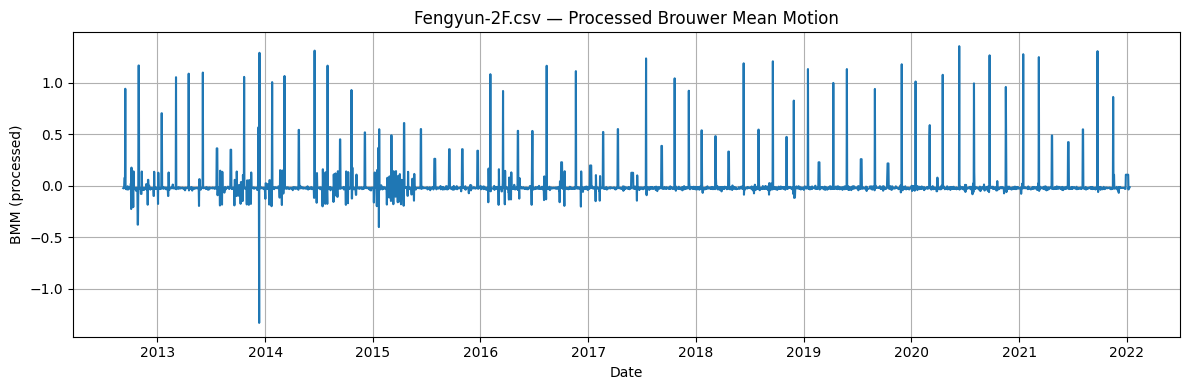

Saved processed series -> /content/Fengyun-2F.csv_BMM_processed.csv

=== Processing Fengyun-2E.csv ===
Missing daily BEFORE interpolation: 405
Any missing AFTER interpolation? False
ADF Statistic: -14.5638 | p-value: 4.747e-27
Stationarity: ✅ Yes (p<0.05)
Time step distribution (top 5):
timestamp
1 days     2746
27 days       1
5 days        1
Name: count, dtype: int64


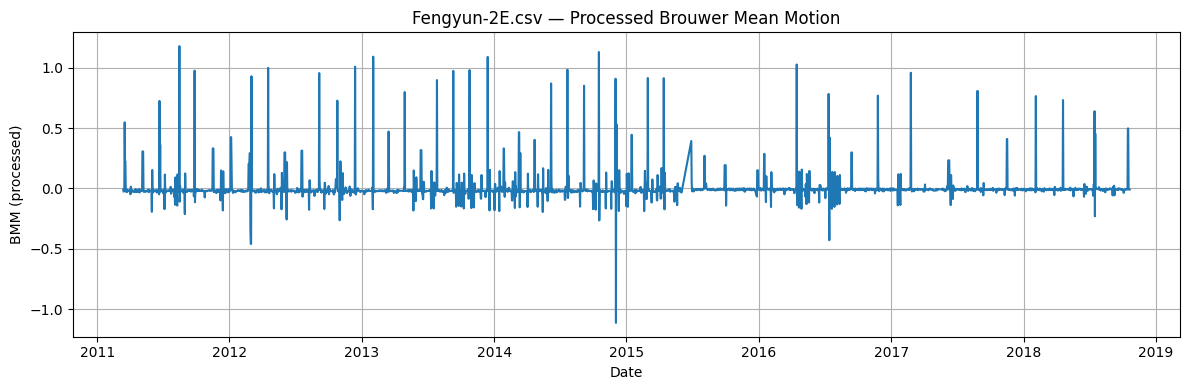

Saved processed series -> /content/Fengyun-2E.csv_BMM_processed.csv

=== Processing Fengyun-2H.csv ===
Missing daily BEFORE interpolation: 55
Any missing AFTER interpolation? False
ADF Statistic: -21.5281 | p-value: 0
Stationarity: ✅ Yes (p<0.05)
Time step distribution (top 5):
timestamp
1 days    1106
Name: count, dtype: int64


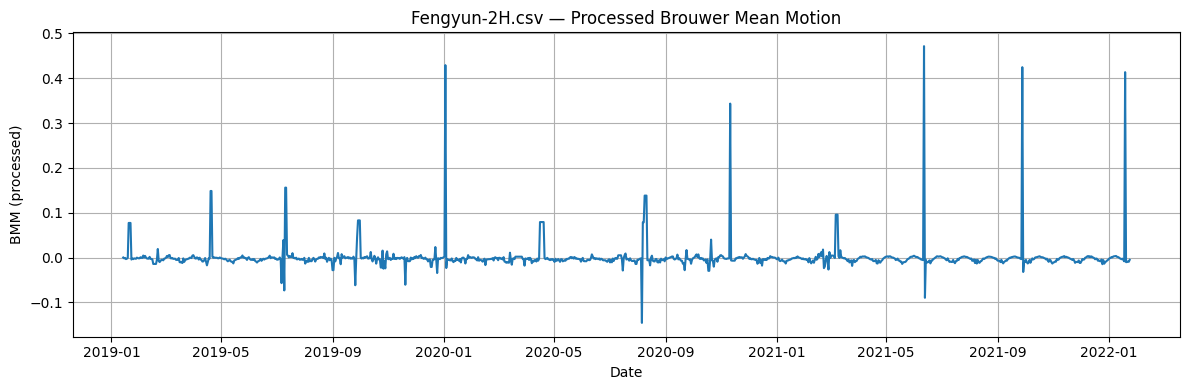

Saved processed series -> /content/Fengyun-2H.csv_BMM_processed.csv

=== Processing Sentinel-3A.csv ===
Missing daily BEFORE interpolation: 16
Any missing AFTER interpolation? False
ADF Statistic: -19.7541 | p-value: 0
Stationarity: ✅ Yes (p<0.05)
Time step distribution (top 5):
timestamp
1 days    2399
Name: count, dtype: int64


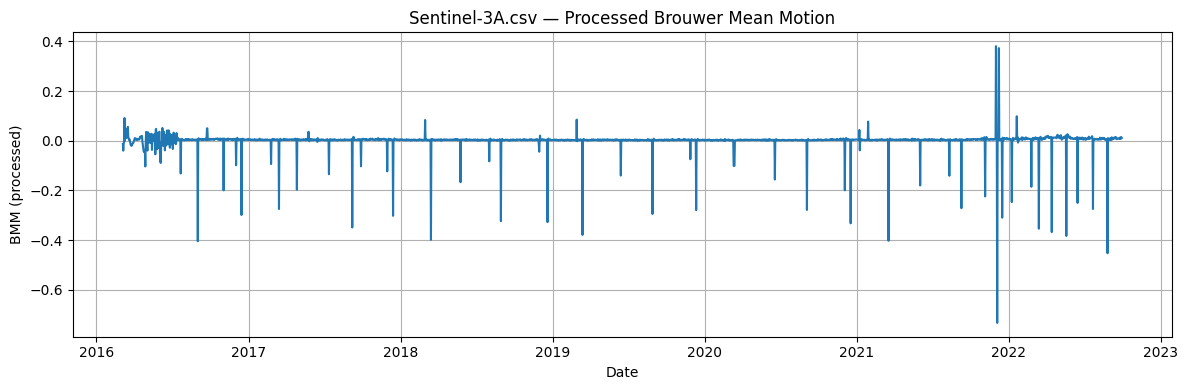

Saved processed series -> /content/Sentinel-3A.csv_BMM_processed.csv

=== Processing SARAL.csv ===
Missing daily BEFORE interpolation: 186
Any missing AFTER interpolation? False
ADF Statistic: -29.4278 | p-value: 0
Stationarity: ✅ Yes (p<0.05)
Time step distribution (top 5):
timestamp
1 days    3474
Name: count, dtype: int64


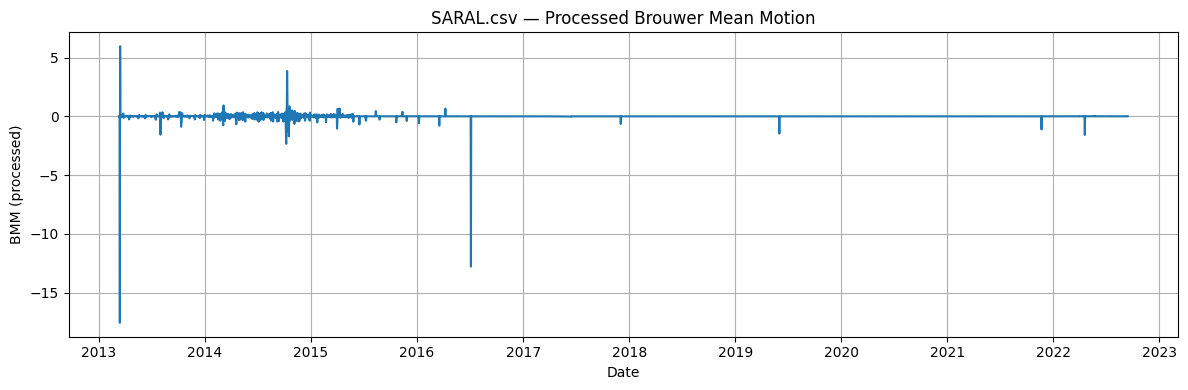

Saved processed series -> /content/SARAL.csv_BMM_processed.csv

Done. 'results' now holds processed series & diagnostics for each satellite.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from statsmodels.tsa.stattools import adfuller

# --- Global Seed Setup ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Inputs
orbital_elements = [
    'Fengyun-2F.csv','Fengyun-2E.csv','Fengyun-2H.csv','Sentinel-3A.csv','SARAL.csv'
]
ground_truth_manoeuvre_timestamps = [
    'manFY2F_cleaned.xlsx','manFY2E_cleaned.xlsx','manFY2H_cleaned.xlsx','cleaned_srlman.xlsx','cleaned_srlman.xlsx'
]

BASE = "/content"  # folder where files are stored

# --- Helpers ---
def load_bmm_series(csv_path, timestamp_col="Unnamed: 0", value_col="Brouwer mean motion"):
    df = pd.read_csv(csv_path)
    df["timestamp"] = pd.to_datetime(df[timestamp_col])
    df = df.set_index("timestamp").sort_index()
    return df[value_col].copy()

def load_ground_truth(xlsx_path):
    truth_df = pd.read_excel(xlsx_path)
    date_cols = ["Start Date", "Date", "start_date", "START_DATE"]
    time_cols = ["Start Time", "Time", "start_time", "START_TIME"]

    date_col = next((c for c in date_cols if c in truth_df.columns), None)
    time_col = next((c for c in time_cols if c in truth_df.columns), None)

    if date_col is not None and time_col is not None:
        ts = pd.to_datetime(truth_df[date_col].astype(str) + " " + truth_df[time_col].astype(str), errors="coerce")
    elif date_col is not None:
        ts = pd.to_datetime(truth_df[date_col], errors="coerce")
    elif "Timestamp" in truth_df.columns:
        ts = pd.to_datetime(truth_df["Timestamp"], errors="coerce")
    else:
        raise ValueError(f"Could not find expected date/time columns in {xlsx_path}")
    return ts.dropna().sort_values().reset_index(drop=True)

def preprocess_bmm(series, sat_name):
    bmm_daily = series.resample("D").mean()
    missing_before = int(bmm_daily.isnull().sum())
    bmm_filled = bmm_daily.interpolate(method="linear")
    missing_after = int(bmm_filled.isnull().sum())

    # Outlier removal only for Fengyun-2E.csv
    if sat_name == "Fengyun-2E.csv":
        q1 = bmm_filled.quantile(0.25)
        q3 = bmm_filled.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        bmm_filled = bmm_filled[(bmm_filled >= lower_bound) & (bmm_filled <= upper_bound)]
    else:
        lower_bound = upper_bound = np.nan

    bmm_scaled = bmm_filled * 1e6
    bmm_diff = bmm_scaled.diff().dropna()

    adf_stat, adf_p, *_ = adfuller(bmm_diff.dropna())
    time_step_distribution = bmm_diff.index.to_series().diff().value_counts()

    diagnostics = {
        "missing_daily_before_interp": missing_before,
        "missing_daily_after_interp": missing_after,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "adf_statistic": adf_stat,
        "adf_pvalue": adf_p,
        "time_step_distribution": time_step_distribution,
    }
    return bmm_diff, diagnostics

def plot_processed(series, sat_name):
    plt.figure(figsize=(12, 4))
    plt.plot(series.index, series.values)
    plt.title(f"{sat_name} — Processed Brouwer Mean Motion")
    plt.ylabel("BMM (processed)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main loop ---
results = {}
for csv_file, gt_file in zip(orbital_elements, ground_truth_manoeuvre_timestamps):
    sat_name = os.path.basename(csv_file)
    csv_path = os.path.join(BASE, csv_file)
    gt_path  = os.path.join(BASE, gt_file)

    print(f"\n=== Processing {sat_name} ===")
    series = load_bmm_series(csv_path)
    gt_ts = load_ground_truth(gt_path)

    processed, diag = preprocess_bmm(series, sat_name)

    print(f"Missing daily BEFORE interpolation: {diag['missing_daily_before_interp']}")
    print(f"Any missing AFTER interpolation? {diag['missing_daily_after_interp'] > 0}")
    print(f"ADF Statistic: {diag['adf_statistic']:.4f} | p-value: {diag['adf_pvalue']:.4g}")
    print("Stationarity:", "✅ Yes (p<0.05)" if diag['adf_pvalue'] < 0.05 else "❌ No (p≥0.05)")
    print("Time step distribution (top 5):")
    print(diag["time_step_distribution"].head())

    # Plot for EVERY satellite
    plot_processed(processed, sat_name)

    # Save processed CSV
    out_path = os.path.join(BASE, f"{sat_name}_BMM_processed.csv")
    processed.rename("BMM_processed").to_csv(out_path)
    print(f"Saved processed series -> {out_path}")

    results[sat_name] = {
        "processed_series": processed,
        "diagnostics": diag,
        "ground_truth_timestamps": gt_ts,
    }

print("\nDone. 'results' now holds processed series & diagnostics for each satellite.")


**2.Hyper-parametric optimisation, Fitting of XGBoost Model**

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.3 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler

# --- Utility to create lagged features ---
def make_lagged_features(series, lag=7):
    df_lagged = pd.DataFrame({'target': series})
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = series.shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

# --- Config ---
SEED = 42
base_lag_values = [5, 10, 15, 20]  # default lags
n_trials = 50

# --- Loop for each satellite ---
all_satellite_results = {}

for sat_name, rec in results.items():
    print(f"\n============================")
    print(f"🚀 Satellite: {sat_name}")
    print(f"============================")

    y_series = rec["processed_series"].dropna().sort_index()

    # For Sentinel-3A, add lag=50
    if sat_name == "Sentinel-3A.csv":
        lag_values = base_lag_values + [50]
    else:
        lag_values = base_lag_values

    lag_study_results = {}

    for LAG in lag_values:
        print(f"\n🚀 Running Optuna for LAG={LAG}")

        # Create lagged features
        lagged_df = make_lagged_features(y_series, lag=LAG)

        # Train-test split
        train_size = int(len(lagged_df) * 0.8)
        train_df = lagged_df.iloc[:train_size]
        test_df = lagged_df.iloc[train_size:]

        X_train = train_df.drop('target', axis=1).values
        y_train = train_df['target'].values
        X_test = test_df.drop('target', axis=1).values
        y_test = test_df['target'].values

        # Objective function
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
                'random_state': SEED,
                'objective': 'reg:squarederror'
            }
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            return mse

        # Optuna study
        sampler = TPESampler(seed=SEED)
        study = optuna.create_study(direction='minimize', sampler=sampler)
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

        # Store results
        lag_study_results[LAG] = {
            "study": study,
            "best_params": study.best_params,
            "best_value": study.best_value
        }

    # 📘 Summary for this satellite
    print("\n📘 Summary of Optuna Results by Lag for", sat_name)
    for lag_val, result in lag_study_results.items():
        print(f"\n🌀 LAG = {lag_val}")
        print(f"Best MSE: {result['best_value']:.6f}")
        print("Best Parameters:")
        for k, v in result['best_params'].items():
            print(f"  {k}: {v}")

    # Save all results for this satellite
    all_satellite_results[sat_name] = lag_study_results


[I 2025-08-14 01:35:41,128] A new study created in memory with name: no-name-dfa477ea-7c1e-495d-b68e-37f0196f6926



🚀 Satellite: Fengyun-2F.csv

🚀 Running Optuna for LAG=5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:35:41,187] Trial 0 finished with value: 0.021486499010613083 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.021486499010613083.
[I 2025-08-14 01:35:41,250] Trial 1 finished with value: 0.022104171793907505 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.021486499010613083.
[I 2025-08-14 01:35:41,298] Trial 2 finished with value: 0.021776893734339272 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:35:46,197] A new study created in memory with name: no-name-29e713a6-f388-4c26-90df-8736add92a87


[I 2025-08-14 01:35:46,094] Trial 48 finished with value: 0.021207586911323982 and parameters: {'n_estimators': 98, 'max_depth': 6, 'learning_rate': 0.013569182764747018, 'subsample': 0.8396660884436047, 'colsample_bytree': 0.8502915612405733, 'gamma': 0.41504802039226757, 'reg_alpha': 0.47483034927717926, 'reg_lambda': 0.303523936556748}. Best is trial 31 with value: 0.020611245205910594.
[I 2025-08-14 01:35:46,180] Trial 49 finished with value: 0.021554525388524197 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.037625087704842984, 'subsample': 0.8878108858578685, 'colsample_bytree': 0.7133595991388583, 'gamma': 0.9220135341848423, 'reg_alpha': 0.2734971551519777, 'reg_lambda': 0.2281800494293859}. Best is trial 31 with value: 0.020611245205910594.

🚀 Running Optuna for LAG=10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:35:46,276] Trial 0 finished with value: 0.02156297324674778 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.02156297324674778.
[I 2025-08-14 01:35:46,384] Trial 1 finished with value: 0.022132860134208312 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.02156297324674778.
[I 2025-08-14 01:35:46,463] Trial 2 finished with value: 0.021783071856855175 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsample_

[I 2025-08-14 01:35:51,308] A new study created in memory with name: no-name-cba00e50-1b8e-408a-ab52-9cf3b3090cb5


[I 2025-08-14 01:35:51,215] Trial 48 finished with value: 0.022163370114405903 and parameters: {'n_estimators': 95, 'max_depth': 9, 'learning_rate': 0.016149642020549165, 'subsample': 0.917630509519303, 'colsample_bytree': 0.6234873022059475, 'gamma': 3.8316046365407663, 'reg_alpha': 0.5721319304895749, 'reg_lambda': 0.710835508697459}. Best is trial 41 with value: 0.020714310421946703.
[I 2025-08-14 01:35:51,288] Trial 49 finished with value: 0.02158979257382095 and parameters: {'n_estimators': 136, 'max_depth': 9, 'learning_rate': 0.05680231294235673, 'subsample': 0.8529616636160795, 'colsample_bytree': 0.8686150388134555, 'gamma': 0.9374342721657178, 'reg_alpha': 0.27195948106937123, 'reg_lambda': 0.7980415235937338}. Best is trial 41 with value: 0.020714310421946703.

🚀 Running Optuna for LAG=15


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:35:51,430] Trial 0 finished with value: 0.021579147171286138 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.021579147171286138.
[I 2025-08-14 01:35:51,567] Trial 1 finished with value: 0.022166910745300424 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.021579147171286138.
[I 2025-08-14 01:35:51,653] Trial 2 finished with value: 0.021839988629825835 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:35:59,736] A new study created in memory with name: no-name-88a88783-9e83-4236-a100-0999c02e7670


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:35:59,865] Trial 0 finished with value: 0.021256076054668473 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.021256076054668473.
[I 2025-08-14 01:36:00,035] Trial 1 finished with value: 0.021860553124592393 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.021256076054668473.
[I 2025-08-14 01:36:00,167] Trial 2 finished with value: 0.021532188502472297 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:36:06,809] A new study created in memory with name: no-name-b416d9bb-2b37-40f7-85fc-b1cba3c23e4f


[I 2025-08-14 01:36:06,790] Trial 49 finished with value: 0.021280499416648852 and parameters: {'n_estimators': 241, 'max_depth': 7, 'learning_rate': 0.05512809719855836, 'subsample': 0.8227181162829955, 'colsample_bytree': 0.6117381015030809, 'gamma': 0.8522453675520569, 'reg_alpha': 0.014819473887236898, 'reg_lambda': 0.6941625389508886}. Best is trial 44 with value: 0.020275933600755778.

📘 Summary of Optuna Results by Lag for Fengyun-2F.csv

🌀 LAG = 5
Best MSE: 0.020611
Best Parameters:
  n_estimators: 144
  max_depth: 7
  learning_rate: 0.06660387777848599
  subsample: 0.9977121054858006
  colsample_bytree: 0.5970895723446366
  gamma: 0.03534695153354229
  reg_alpha: 0.66806815211721
  reg_lambda: 0.5497806165139215

🌀 LAG = 10
Best MSE: 0.020714
Best Parameters:
  n_estimators: 110
  max_depth: 8
  learning_rate: 0.0797935268763315
  subsample: 0.6945710559675395
  colsample_bytree: 0.8108130204825426
  gamma: 0.03566377576849536
  reg_alpha: 0.49149655286672705
  reg_lambda: 0.7

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:06,879] Trial 0 finished with value: 0.006560058466354786 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.006560058466354786.
[I 2025-08-14 01:36:06,917] Trial 1 finished with value: 0.006626840494184102 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.006560058466354786.
[I 2025-08-14 01:36:06,957] Trial 2 finished with value: 0.006605882068275539 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:36:11,839] A new study created in memory with name: no-name-92a5b798-38fe-4b82-adc9-c331ceb07cb6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:11,921] Trial 0 finished with value: 0.00658226912631261 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.00658226912631261.
[I 2025-08-14 01:36:11,972] Trial 1 finished with value: 0.006639154797090016 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.00658226912631261.
[I 2025-08-14 01:36:12,018] Trial 2 finished with value: 0.006624902753316461 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsample_

[I 2025-08-14 01:36:16,409] A new study created in memory with name: no-name-0ea8c316-a7ca-4432-9da6-16e9962d7c0b


[I 2025-08-14 01:36:16,393] Trial 49 finished with value: 0.006638309336611195 and parameters: {'n_estimators': 121, 'max_depth': 5, 'learning_rate': 0.2119421076234983, 'subsample': 0.6086800652561348, 'colsample_bytree': 0.9737729928207507, 'gamma': 4.00046019068776, 'reg_alpha': 0.3245378111588131, 'reg_lambda': 0.3254766657287884}. Best is trial 47 with value: 0.006221072923059413.

🚀 Running Optuna for LAG=15


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:16,506] Trial 0 finished with value: 0.006588199703404891 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.006588199703404891.
[I 2025-08-14 01:36:16,567] Trial 1 finished with value: 0.0066510267631970455 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.006588199703404891.
[I 2025-08-14 01:36:16,632] Trial 2 finished with value: 0.006633558357438324 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsam

[I 2025-08-14 01:36:23,360] A new study created in memory with name: no-name-7b88d565-d4f6-4fe2-acfe-b405ee5d228d


[I 2025-08-14 01:36:23,160] Trial 47 finished with value: 0.00629317832943371 and parameters: {'n_estimators': 135, 'max_depth': 8, 'learning_rate': 0.29092210314176437, 'subsample': 0.5046415888966249, 'colsample_bytree': 0.829389786651561, 'gamma': 0.10620653571312974, 'reg_alpha': 0.35332877981695965, 'reg_lambda': 0.8734526721165312}. Best is trial 22 with value: 0.00613191103373804.
[I 2025-08-14 01:36:23,256] Trial 48 finished with value: 0.006650840402139129 and parameters: {'n_estimators': 162, 'max_depth': 9, 'learning_rate': 0.05011284993142535, 'subsample': 0.6772627167597305, 'colsample_bytree': 0.9255996269643268, 'gamma': 3.8316046365407663, 'reg_alpha': 0.5825047389932868, 'reg_lambda': 0.3926684231000559}. Best is trial 22 with value: 0.00613191103373804.
[I 2025-08-14 01:36:23,326] Trial 49 finished with value: 0.006375849026883111 and parameters: {'n_estimators': 97, 'max_depth': 7, 'learning_rate': 0.223377747666857, 'subsample': 0.6422747469093382, 'colsample_bytree

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:23,472] Trial 0 finished with value: 0.0065927691591850255 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.0065927691591850255.
[I 2025-08-14 01:36:23,551] Trial 1 finished with value: 0.006662879978623663 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.0065927691591850255.
[I 2025-08-14 01:36:23,603] Trial 2 finished with value: 0.006641995966359575 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'cols

[I 2025-08-14 01:36:30,428] A new study created in memory with name: no-name-4fac2686-f7f8-48c8-aae7-90dbc219b279


[I 2025-08-14 01:36:30,284] Trial 48 finished with value: 0.006662831914073086 and parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.004497682604243661, 'subsample': 0.7700336342921523, 'colsample_bytree': 0.8888692602085908, 'gamma': 3.8316046365407663, 'reg_alpha': 0.37196264175443683, 'reg_lambda': 0.7608742277359258}. Best is trial 31 with value: 0.0061425936155359755.
[I 2025-08-14 01:36:30,405] Trial 49 finished with value: 0.0066626384363083335 and parameters: {'n_estimators': 149, 'max_depth': 7, 'learning_rate': 0.014502407785021602, 'subsample': 0.7444452474866176, 'colsample_bytree': 0.7359767350948349, 'gamma': 1.2882999286024106, 'reg_alpha': 0.45577108123976845, 'reg_lambda': 0.3079471818072155}. Best is trial 31 with value: 0.0061425936155359755.

📘 Summary of Optuna Results by Lag for Fengyun-2E.csv

🌀 LAG = 5
Best MSE: 0.006294
Best Parameters:
  n_estimators: 251
  max_depth: 9
  learning_rate: 0.06187756998698821
  subsample: 0.64603126013113
  col

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:30,500] Trial 0 finished with value: 0.0016289632787996216 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.0016289632787996216.
[I 2025-08-14 01:36:30,559] Trial 1 finished with value: 0.0016289527176160403 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0016289527176160403.
[I 2025-08-14 01:36:30,610] Trial 2 finished with value: 0.0016289478735310467 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'co

[I 2025-08-14 01:36:35,130] A new study created in memory with name: no-name-d717b999-56f5-4ac6-9bf6-717776712abd


[I 2025-08-14 01:36:34,980] Trial 48 finished with value: 0.0016288886245658318 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.05168283229888119, 'subsample': 0.6467284537654775, 'colsample_bytree': 0.6820539306604672, 'gamma': 1.667389843166858, 'reg_alpha': 0.35177879970485787, 'reg_lambda': 0.5138602891030077}. Best is trial 47 with value: 0.0016288828421796178.
[I 2025-08-14 01:36:35,109] Trial 49 finished with value: 0.0016289278858568736 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.010704025174975044, 'subsample': 0.6118363528465347, 'colsample_bytree': 0.6902034665329203, 'gamma': 1.6381147596605712, 'reg_alpha': 0.3497400518245252, 'reg_lambda': 0.5246081961971691}. Best is trial 47 with value: 0.0016288828421796178.

🚀 Running Optuna for LAG=10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:35,241] Trial 0 finished with value: 0.0016360862000233641 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.0016360862000233641.
[I 2025-08-14 01:36:35,368] Trial 1 finished with value: 0.0016360860467070854 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0016360860467070854.
[I 2025-08-14 01:36:35,465] Trial 2 finished with value: 0.0016360860503913497 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'co

[I 2025-08-14 01:36:39,461] A new study created in memory with name: no-name-c0714e73-dacb-4930-ba11-9f60ef22e521


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:39,564] Trial 0 finished with value: 0.0016427720772942877 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.0016427720772942877.
[I 2025-08-14 01:36:39,629] Trial 1 finished with value: 0.0016427634389119795 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0016427634389119795.
[I 2025-08-14 01:36:39,667] Trial 2 finished with value: 0.001642766612311338 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'col

[I 2025-08-14 01:36:43,913] A new study created in memory with name: no-name-8740b9f4-508d-4cf7-9a9e-f3cb2d813201


[I 2025-08-14 01:36:43,895] Trial 49 finished with value: 0.001642759960644511 and parameters: {'n_estimators': 282, 'max_depth': 7, 'learning_rate': 0.10981270068398558, 'subsample': 0.5239540374628348, 'colsample_bytree': 0.5508869137541369, 'gamma': 4.810829829871913, 'reg_alpha': 0.8474347121016277, 'reg_lambda': 0.5479670633080571}. Best is trial 37 with value: 0.0016427595200652933.

🚀 Running Optuna for LAG=20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:44,036] Trial 0 finished with value: 0.001650115340973395 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.001650115340973395.
[I 2025-08-14 01:36:44,121] Trial 1 finished with value: 0.0016500826453953454 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0016500826453953454.
[I 2025-08-14 01:36:44,191] Trial 2 finished with value: 0.0016500824824496514 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'cols

[I 2025-08-14 01:36:50,556] A new study created in memory with name: no-name-74b967ca-2f18-44f7-adcf-b50a953b64df


[I 2025-08-14 01:36:50,544] Trial 49 finished with value: 0.0016500972924369352 and parameters: {'n_estimators': 244, 'max_depth': 8, 'learning_rate': 0.11052397554145955, 'subsample': 0.7364307347733828, 'colsample_bytree': 0.5742727480448717, 'gamma': 4.59763116281364, 'reg_alpha': 0.2169621434027368, 'reg_lambda': 0.2646692086640928}. Best is trial 21 with value: 0.0016500731233746052.

📘 Summary of Optuna Results by Lag for Fengyun-2H.csv

🌀 LAG = 5
Best MSE: 0.001629
Best Parameters:
  n_estimators: 185
  max_depth: 3
  learning_rate: 0.04775283991453705
  subsample: 0.6525095024077675
  colsample_bytree: 0.6771291535654584
  gamma: 1.6509170050658604
  reg_alpha: 0.35612529736792115
  reg_lambda: 0.5209579953143052

🌀 LAG = 10
Best MSE: 0.001636
Best Parameters:
  n_estimators: 298
  max_depth: 5
  learning_rate: 0.004715181869011494
  subsample: 0.5048579886309473
  colsample_bytree: 0.5872625990747572
  gamma: 3.482741304273752
  reg_alpha: 0.999362438641551
  reg_lambda: 0.719

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:50,634] Trial 0 finished with value: 0.004073515653229782 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004073515653229782.
[I 2025-08-14 01:36:50,705] Trial 1 finished with value: 0.004073542028073036 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.004073515653229782.
[I 2025-08-14 01:36:50,773] Trial 2 finished with value: 0.004073536610379327 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:36:54,445] A new study created in memory with name: no-name-f7c7280c-0130-4e66-afa2-0d2bf93870c9


[I 2025-08-14 01:36:54,431] Trial 49 finished with value: 0.004073504863675532 and parameters: {'n_estimators': 167, 'max_depth': 7, 'learning_rate': 0.012676501253318668, 'subsample': 0.7369984976130746, 'colsample_bytree': 0.6200272116233878, 'gamma': 4.150645785025086, 'reg_alpha': 0.6482025835094305, 'reg_lambda': 0.3254766657287884}. Best is trial 43 with value: 0.004073442027483631.

🚀 Running Optuna for LAG=10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:54,529] Trial 0 finished with value: 0.004082011341546315 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004082011341546315.
[I 2025-08-14 01:36:54,625] Trial 1 finished with value: 0.004082066857706448 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 0 with value: 0.004082011341546315.
[I 2025-08-14 01:36:54,708] Trial 2 finished with value: 0.0040820567592394765 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsam

[I 2025-08-14 01:36:59,362] A new study created in memory with name: no-name-835348f4-2202-4efc-9a5d-7bdc5853d7eb


[I 2025-08-14 01:36:59,336] Trial 49 finished with value: 0.004081971689204494 and parameters: {'n_estimators': 160, 'max_depth': 9, 'learning_rate': 0.07280520401411301, 'subsample': 0.6013644096274852, 'colsample_bytree': 0.7197236988071333, 'gamma': 4.967411011074679, 'reg_alpha': 0.38635685053532676, 'reg_lambda': 0.6827578434872235}. Best is trial 27 with value: 0.004081938795512987.

🚀 Running Optuna for LAG=15


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:36:59,498] Trial 0 finished with value: 0.004090750933732612 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004090750933732612.
[I 2025-08-14 01:36:59,644] Trial 1 finished with value: 0.0040906673054626344 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0040906673054626344.
[I 2025-08-14 01:36:59,777] Trial 2 finished with value: 0.004090672801950399 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsa

[I 2025-08-14 01:37:05,283] A new study created in memory with name: no-name-3184479e-b989-4799-977b-f453915917f8


[I 2025-08-14 01:37:05,167] Trial 48 finished with value: 0.004090499148187354 and parameters: {'n_estimators': 276, 'max_depth': 10, 'learning_rate': 0.217337139649861, 'subsample': 0.5196929930043808, 'colsample_bytree': 0.6679441753448508, 'gamma': 2.846482416163596, 'reg_alpha': 0.6757706186758291, 'reg_lambda': 0.23074690850869162}. Best is trial 10 with value: 0.004090479967931486.
[I 2025-08-14 01:37:05,263] Trial 49 finished with value: 0.00409060098639343 and parameters: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.10670908320511226, 'subsample': 0.721646027303734, 'colsample_bytree': 0.705898941363694, 'gamma': 4.2438612386158585, 'reg_alpha': 0.38635685053532676, 'reg_lambda': 0.2817253292186165}. Best is trial 10 with value: 0.004090479967931486.

🚀 Running Optuna for LAG=20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:37:05,408] Trial 0 finished with value: 0.004099214319981026 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004099214319981026.
[I 2025-08-14 01:37:05,542] Trial 1 finished with value: 0.004099204725068331 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.004099204725068331.
[I 2025-08-14 01:37:05,618] Trial 2 finished with value: 0.004099199129373294 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:37:11,047] A new study created in memory with name: no-name-6f619175-90f8-495a-bcf5-fbe12f95e200


[I 2025-08-14 01:37:11,015] Trial 49 finished with value: 0.004099177889816333 and parameters: {'n_estimators': 252, 'max_depth': 6, 'learning_rate': 0.20852778881800038, 'subsample': 0.988293088919235, 'colsample_bytree': 0.9508898321800193, 'gamma': 0.8171476210390889, 'reg_alpha': 0.6468766100217804, 'reg_lambda': 0.3980890563641335}. Best is trial 20 with value: 0.004099072713024698.

🚀 Running Optuna for LAG=50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:37:11,291] Trial 0 finished with value: 0.004151267229863532 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.004151267229863532.
[I 2025-08-14 01:37:11,593] Trial 1 finished with value: 0.004151264333972639 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.004151264333972639.
[I 2025-08-14 01:37:11,893] Trial 2 finished with value: 0.004151280359057328 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:37:20,478] A new study created in memory with name: no-name-f274e480-fa0a-4a1e-9761-6b2351fa0ee8


[I 2025-08-14 01:37:20,463] Trial 49 finished with value: 0.0041512645516026195 and parameters: {'n_estimators': 62, 'max_depth': 3, 'learning_rate': 0.04928474388428696, 'subsample': 0.9996860926484777, 'colsample_bytree': 0.811186453862899, 'gamma': 4.5690792759933245, 'reg_alpha': 0.8360945307398417, 'reg_lambda': 0.6597113902803098}. Best is trial 38 with value: 0.004149837715528517.

📘 Summary of Optuna Results by Lag for Sentinel-3A.csv

🌀 LAG = 5
Best MSE: 0.004073
Best Parameters:
  n_estimators: 170
  max_depth: 6
  learning_rate: 0.27129222695980015
  subsample: 0.7835499391644245
  colsample_bytree: 0.6786072988012457
  gamma: 1.0150656425368878
  reg_alpha: 0.6361310147278245
  reg_lambda: 0.4305401941703333

🌀 LAG = 10
Best MSE: 0.004082
Best Parameters:
  n_estimators: 140
  max_depth: 7
  learning_rate: 0.13815047300788236
  subsample: 0.555852567387078
  colsample_bytree: 0.7390135402481219
  gamma: 2.0120003222547718
  reg_alpha: 0.5267426265770458
  reg_lambda: 0.4420

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:37:20,619] Trial 0 finished with value: 0.0054787386553650065 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.0054787386553650065.
[I 2025-08-14 01:37:20,748] Trial 1 finished with value: 0.005471029819654144 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.005471029819654144.
[I 2025-08-14 01:37:20,830] Trial 2 finished with value: 0.0055257385317932185 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'cols

[I 2025-08-14 01:37:26,587] A new study created in memory with name: no-name-d7a52546-7a81-4bca-bb9c-3efdc00366b4


[I 2025-08-14 01:37:26,498] Trial 48 finished with value: 0.005479140476212784 and parameters: {'n_estimators': 209, 'max_depth': 7, 'learning_rate': 0.11882583858895908, 'subsample': 0.9387751281721941, 'colsample_bytree': 0.7380464158330826, 'gamma': 3.166450995422897, 'reg_alpha': 0.5082024378536354, 'reg_lambda': 0.5861731230063225}. Best is trial 6 with value: 0.005461485516599147.
[I 2025-08-14 01:37:26,574] Trial 49 finished with value: 0.005470886525382366 and parameters: {'n_estimators': 85, 'max_depth': 4, 'learning_rate': 0.009846557964982804, 'subsample': 0.9996860926484777, 'colsample_bytree': 0.811647696392076, 'gamma': 3.5551902937181947, 'reg_alpha': 0.34017281875159117, 'reg_lambda': 0.027271430713573186}. Best is trial 6 with value: 0.005461485516599147.

🚀 Running Optuna for LAG=10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:37:26,787] Trial 0 finished with value: 0.005504458951391578 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.005504458951391578.
[I 2025-08-14 01:37:26,967] Trial 1 finished with value: 0.005479408608808362 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.005479408608808362.
[I 2025-08-14 01:37:27,081] Trial 2 finished with value: 0.005476719604928855 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 01:37:31,929] A new study created in memory with name: no-name-3ddbace1-7882-4b24-b2f8-2a01a4c9c85f


[I 2025-08-14 01:37:31,901] Trial 49 finished with value: 0.005479180978967868 and parameters: {'n_estimators': 192, 'max_depth': 5, 'learning_rate': 0.19330024073158603, 'subsample': 0.9997837678405108, 'colsample_bytree': 0.6687240962475142, 'gamma': 2.155321585597093, 'reg_alpha': 0.804497039322333, 'reg_lambda': 0.7217117908846454}. Best is trial 4 with value: 0.005464423102635153.

🚀 Running Optuna for LAG=15


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:37:32,110] Trial 0 finished with value: 0.005496248761112096 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.005496248761112096.
[I 2025-08-14 01:37:32,306] Trial 1 finished with value: 0.0054887118203254546 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0054887118203254546.
[I 2025-08-14 01:37:32,452] Trial 2 finished with value: 0.005484812606519443 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsa

[I 2025-08-14 01:37:39,648] A new study created in memory with name: no-name-43648fa9-36ef-45d4-9545-09ad0155c40e


[I 2025-08-14 01:37:39,528] Trial 48 finished with value: 0.005487355559363647 and parameters: {'n_estimators': 271, 'max_depth': 3, 'learning_rate': 0.0009630145659909942, 'subsample': 0.791820258548561, 'colsample_bytree': 0.7282747627739414, 'gamma': 0.27169002724450925, 'reg_alpha': 0.5650624305827767, 'reg_lambda': 0.4791157469030409}. Best is trial 4 with value: 0.005472741050564156.
[I 2025-08-14 01:37:39,628] Trial 49 finished with value: 0.006015703937318057 and parameters: {'n_estimators': 127, 'max_depth': 6, 'learning_rate': 0.19302735299947246, 'subsample': 0.6810394981349689, 'colsample_bytree': 0.8035296809041601, 'gamma': 0.5881366429435279, 'reg_alpha': 0.38804364816806736, 'reg_lambda': 0.13395066529531952}. Best is trial 4 with value: 0.005472741050564156.

🚀 Running Optuna for LAG=20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 01:37:39,866] Trial 0 finished with value: 0.005510142568080607 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.005510142568080607.
[I 2025-08-14 01:37:40,091] Trial 1 finished with value: 0.005496921640641925 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.005496921640641925.
[I 2025-08-14 01:37:40,278] Trial 2 finished with value: 0.005518363743870489 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

In [7]:
from xgboost import XGBRegressor

# --- Storage for final models and residuals per satellite ---
final_models_all = {}
residuals_all = {}

# --- Loop over each satellite from previous tuning ---
for sat_name, lag_results in all_satellite_results.items():
    print(f"\n==============================")
    print(f"📦 Retraining best models for satellite: {sat_name}")
    print(f"==============================")

    # Get processed series for this satellite
    series_full = results[sat_name]["processed_series"].dropna().sort_index()

    # Prepare storage for this satellite
    final_models_all[sat_name] = {}
    residuals_all[sat_name] = {}

    # Loop over each lag from tuning history
    for LAG, result in lag_results.items():
        print(f"\n🔄 Retraining model on FULL data for LAG = {LAG}...")

        # Step 1: Create lagged dataframe
        lagged_df = pd.DataFrame({'target': series_full})
        for i in range(1, LAG + 1):
            lagged_df[f'lag_{i}'] = series_full.shift(i)
        lagged_df.dropna(inplace=True)

        # Step 2: Prepare full dataset
        X_full = lagged_df.drop("target", axis=1).values
        y_full = lagged_df["target"].values

        # Step 3: Load best parameters from tuning results
        best_params = result["best_params"].copy()
        best_params.update({
            "objective": "reg:squarederror",
            "random_state": SEED
        })

        # Step 4: Train final model
        model = XGBRegressor(**best_params)
        model.fit(X_full, y_full)

        # Step 5: Store model and residuals
        final_models_all[sat_name][LAG] = model
        y_pred = model.predict(X_full)
        residuals = y_full - y_pred
        residuals_all[sat_name][LAG] = pd.Series(residuals, index=lagged_df.index)

        print(f"✅ Model trained and residuals saved for LAG = {LAG}")

print("\n🎯 All models retrained and residuals stored in final_models_all / residuals_all.")



📦 Retraining best models for satellite: Fengyun-2F.csv

🔄 Retraining model on FULL data for LAG = 5...
✅ Model trained and residuals saved for LAG = 5

🔄 Retraining model on FULL data for LAG = 10...
✅ Model trained and residuals saved for LAG = 10

🔄 Retraining model on FULL data for LAG = 15...
✅ Model trained and residuals saved for LAG = 15

🔄 Retraining model on FULL data for LAG = 20...
✅ Model trained and residuals saved for LAG = 20

📦 Retraining best models for satellite: Fengyun-2E.csv

🔄 Retraining model on FULL data for LAG = 5...
✅ Model trained and residuals saved for LAG = 5

🔄 Retraining model on FULL data for LAG = 10...
✅ Model trained and residuals saved for LAG = 10

🔄 Retraining model on FULL data for LAG = 15...
✅ Model trained and residuals saved for LAG = 15

🔄 Retraining model on FULL data for LAG = 20...
✅ Model trained and residuals saved for LAG = 20

📦 Retraining best models for satellite: Fengyun-2H.csv

🔄 Retraining model on FULL data for LAG = 5...
✅ Mo

**3.Qualitative Analysis**

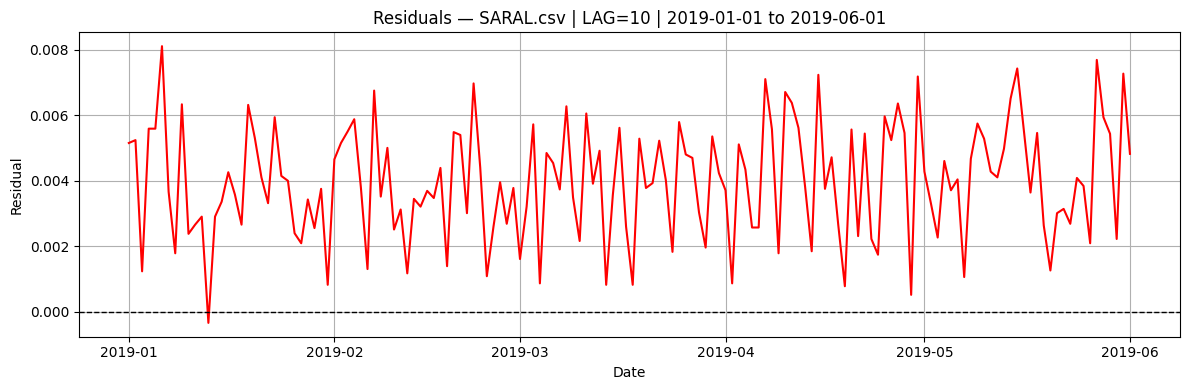

In [11]:
import matplotlib.pyplot as plt

def plot_residuals_for_sat_lag(
    sat_name: str,
    lag: int,
    start_date: str = "2019-01-01",
    end_date: str = "2019-06-01"
):
    """
    Plot residuals for a given satellite and lag over a fixed (or custom) time window.

    Args:
        sat_name: Satellite name in residuals_all (e.g., "Fengyun-2E.csv")
        lag: Lag value to visualize
        start_date: Start date for the plot (YYYY-MM-DD)
        end_date: End date for the plot (YYYY-MM-DD)
    """
    if sat_name not in residuals_all:
        print(f"❌ Satellite '{sat_name}' not found. Available: {list(residuals_all.keys())}")
        return
    if lag not in residuals_all[sat_name]:
        print(f"❌ Lag {lag} not found for '{sat_name}'. Available lags: {list(residuals_all[sat_name].keys())}")
        return

    residual_series = residuals_all[sat_name][lag]
    residual_window = residual_series.loc[start_date:end_date]

    plt.figure(figsize=(12, 4))
    plt.plot(residual_window.index, residual_window.values, color="red")
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Residuals — {sat_name} | LAG={lag} | {start_date} to {end_date}")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_residuals_for_sat_lag("SARAL.csv", 10)

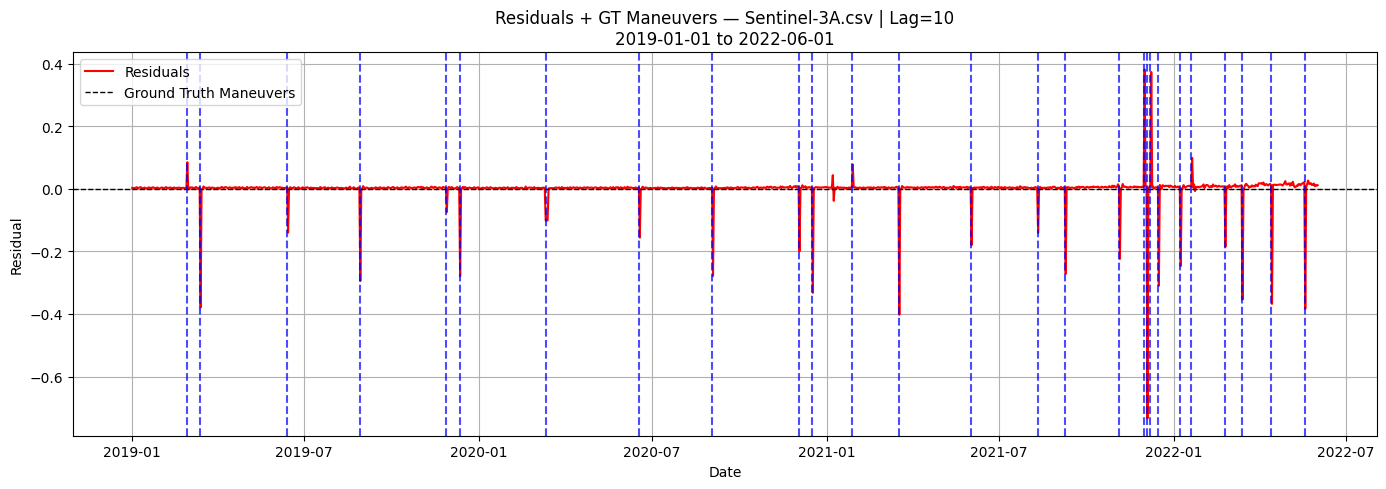

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_residuals_with_gt_for_sat_lag(
    sat_name: str,
    lag: int,
    start_date: str = "2019-01-01",
    end_date: str = "2022-06-01"
):
    """
    Plot residuals with ground truth maneuver overlay for a given satellite and lag.

    Args:
        sat_name: Satellite name in residuals_all (e.g., "Fengyun-2E.csv")
        lag: Lag value to plot
        start_date: Start date for the plot (YYYY-MM-DD)
        end_date: End date for the plot (YYYY-MM-DD)
    """
    # --- Check if satellite and lag exist ---
    if sat_name not in residuals_all:
        print(f"❌ Satellite '{sat_name}' not found. Available: {list(residuals_all.keys())}")
        return
    if lag not in residuals_all[sat_name]:
        print(f"❌ Lag {lag} not found for '{sat_name}'. Available lags: {list(residuals_all[sat_name].keys())}")
        return

    # --- Map to correct GT file ---
    gt_file_map = {
        "Fengyun-2F.csv": "/content/manFY2F_cleaned.xlsx",
        "Fengyun-2E.csv": "/content/manFY2E_cleaned.xlsx",
        "Fengyun-2H.csv": "/content/manFY2H_cleaned.xlsx",
        "Sentinel-3A.csv": "/content/cleaned_s3aman.xlsx",  # ✅ corrected mapping
        "SARAL.csv": "/content/cleaned_srlman.xlsx"
    }
    if sat_name not in gt_file_map:
        print(f"⚠️ No ground truth mapping for '{sat_name}'.")
        return

    # --- Load ground truth timestamps ---
    truth_df = pd.read_excel(gt_file_map[sat_name])
    if "Start Date" in truth_df.columns and "Start Time" in truth_df.columns:
        ground_truth_timestamps = pd.to_datetime(
            truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
        )
    elif "Date" in truth_df.columns:
        ground_truth_timestamps = pd.to_datetime(truth_df["Date"])
    else:
        print(f"⚠️ No recognizable date/time columns in {gt_file_map[sat_name]}")
        return

    # --- Get residuals for this satellite and lag ---
    residual_series = residuals_all[sat_name][lag]
    residual_window = residual_series.loc[start_date:end_date]

    # --- Filter GT timestamps to window ---
    gt_in_window = ground_truth_timestamps[
        (ground_truth_timestamps >= pd.to_datetime(start_date)) &
        (ground_truth_timestamps <= pd.to_datetime(end_date))
    ]

    # --- Plot ---
    plt.figure(figsize=(14, 5))
    plt.plot(residual_window.index, residual_window.values, color='red', label='Residuals')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    for ts in gt_in_window:
        plt.axvline(ts, color='blue', linestyle='--', alpha=0.7)

    plt.title(f"Residuals + GT Maneuvers — {sat_name} | Lag={lag}\n{start_date} to {end_date}")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.legend(["Residuals", "Ground Truth Maneuvers"])
    plt.tight_layout()
    plt.show()
plot_residuals_with_gt_for_sat_lag("Sentinel-3A.csv", 10)

**4.Quantitative Analysis**


=== Precision–Recall sweep for Fengyun-2F.csv ===


/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[

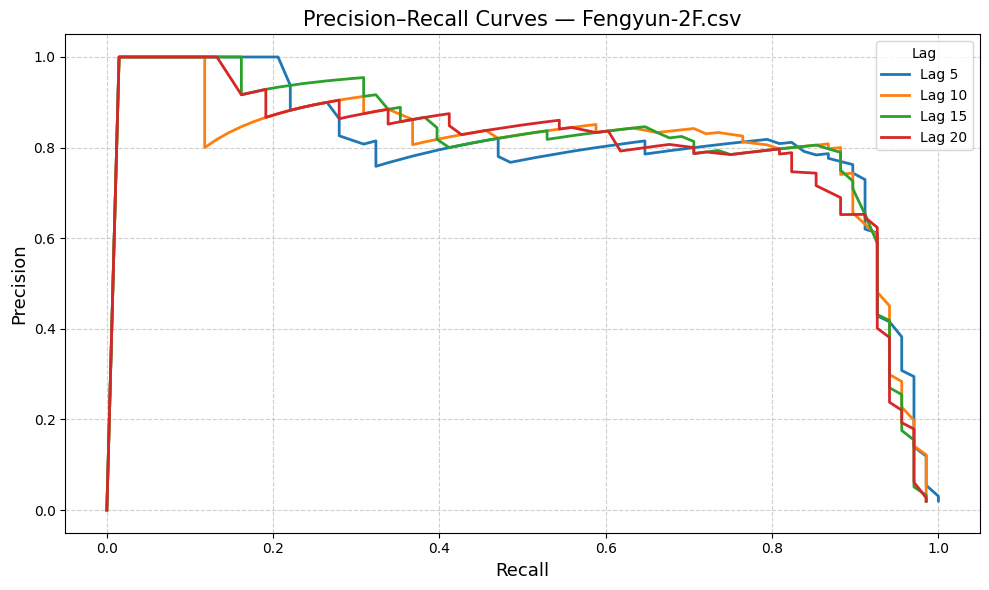

Top configurations for Fengyun-2F.csv:


,Satellite,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,Fengyun-2F.csv,10,0.223201,0.800000,0.882353,0.839161,60,15,8,0.801165
1,Fengyun-2F.csv,15,0.212053,0.789474,0.882353,0.833333,60,16,8,0.809686
2,Fengyun-2F.csv,5,0.257313,0.786667,0.867647,0.825175,59,16,9,0.793327
3,Fengyun-2F.csv,20,0.309809,0.788732,0.823529,0.805755,56,15,12,0.794630



=== Precision–Recall sweep for Fengyun-2E.csv ===


/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[

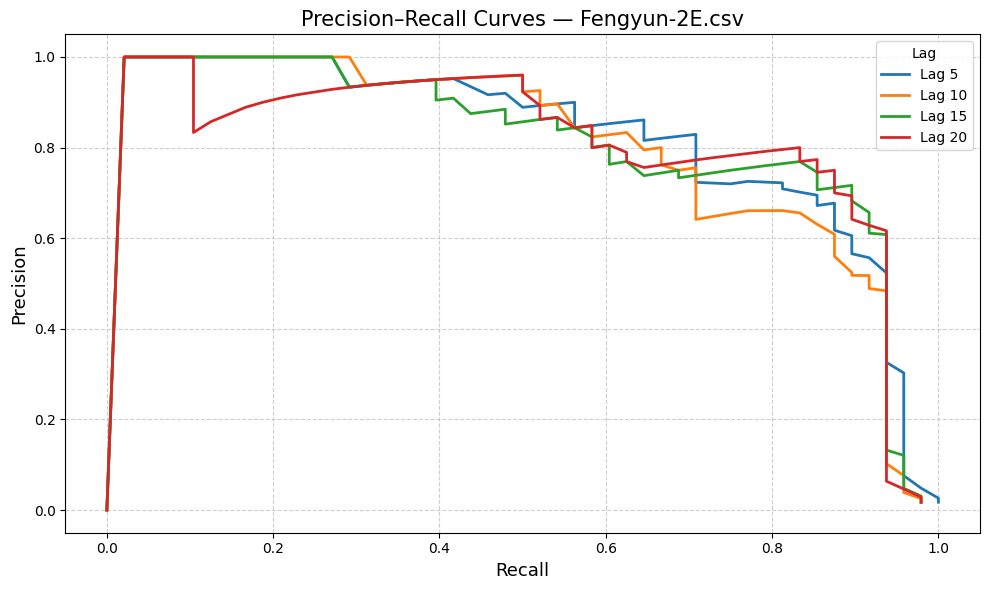

Top configurations for Fengyun-2E.csv:


,Satellite,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,Fengyun-2E.csv,20,0.277089,0.800000,0.833333,0.816327,40,10,8,0.802431
1,Fengyun-2E.csv,15,0.259584,0.769231,0.833333,0.800000,40,12,8,0.810064
2,Fengyun-2E.csv,5,0.282762,0.694915,0.854167,0.766355,41,18,7,0.815525
3,Fengyun-2E.csv,10,0.293861,0.655738,0.833333,0.733945,40,21,8,0.797821



=== Precision–Recall sweep for Fengyun-2H.csv ===


/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[

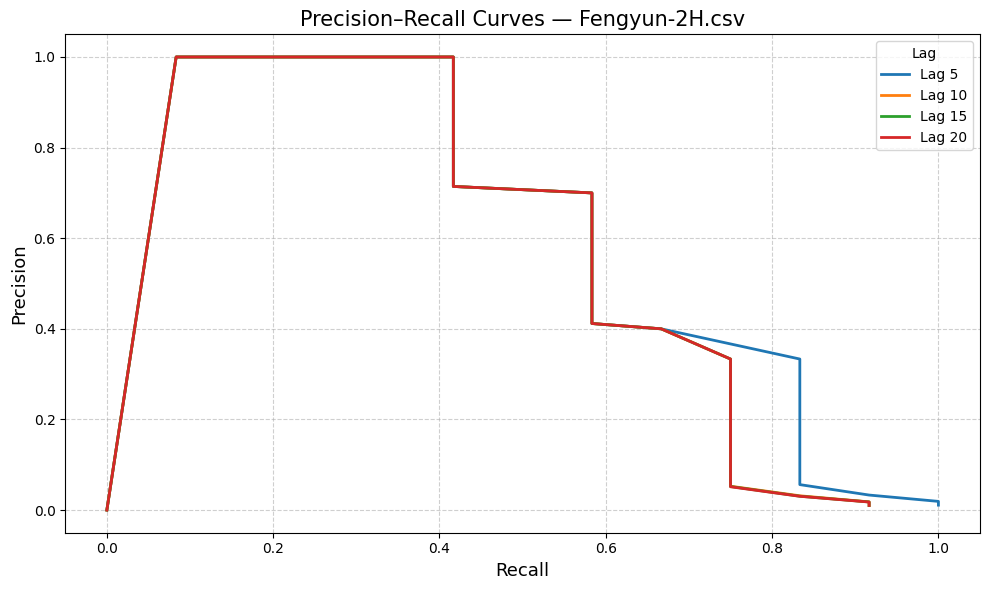

Top configurations for Fengyun-2H.csv:


,Satellite,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,Fengyun-2H.csv,5,0.139169,0.7,0.583333,0.636364,7,3,5,0.614972
1,Fengyun-2H.csv,10,0.139214,0.7,0.583333,0.636364,7,3,5,0.585483
2,Fengyun-2H.csv,15,0.139186,0.7,0.583333,0.636364,7,3,5,0.585397
3,Fengyun-2H.csv,20,0.139172,0.7,0.583333,0.636364,7,3,5,0.585372



=== Precision–Recall sweep for Sentinel-3A.csv ===


/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[

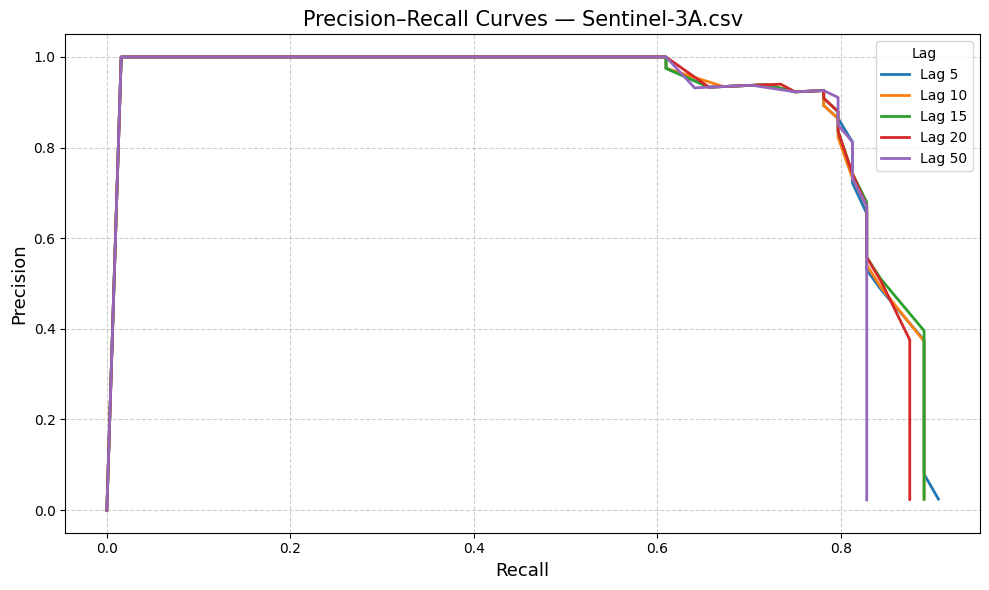

Top configurations for Sentinel-3A.csv:


,Satellite,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,Sentinel-3A.csv,50,0.050056,0.910714,0.796875,0.850000,51,5,13,0.796224
1,Sentinel-3A.csv,5,0.059084,0.925926,0.781250,0.847458,50,4,14,0.823523
2,Sentinel-3A.csv,10,0.059081,0.925926,0.781250,0.847458,50,4,14,0.824945
3,Sentinel-3A.csv,15,0.059080,0.925926,0.781250,0.847458,50,4,14,0.825878
4,Sentinel-3A.csv,20,0.059069,0.925926,0.781250,0.847458,50,4,14,0.819968



=== Precision–Recall sweep for SARAL.csv ===


/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])
/tmp/ipython-input-4013597332.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[

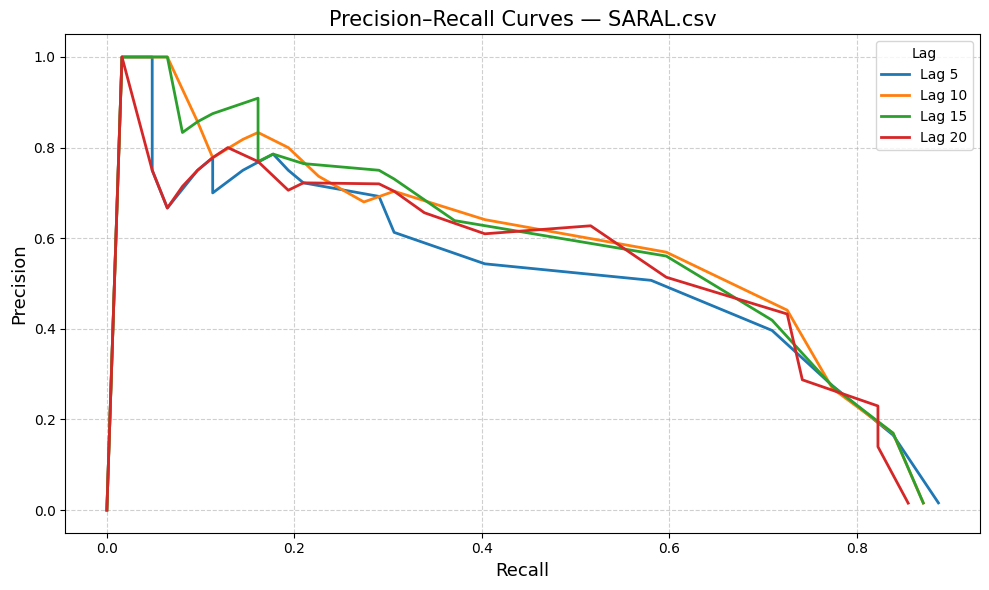

Top configurations for SARAL.csv:


,Satellite,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,SARAL.csv,10,0.343559,0.569231,0.596774,0.582677,37,28,25,0.528014
1,SARAL.csv,15,0.343534,0.560606,0.596774,0.578125,37,29,25,0.525234
2,SARAL.csv,20,0.373144,0.627451,0.516129,0.566372,32,19,30,0.492655
3,SARAL.csv,5,0.343505,0.507042,0.580645,0.541353,36,35,26,0.475931



🏁 Best configurations per satellite (sorted by highest F1):


,Satellite,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,Sentinel-3A.csv,50,0.050056,0.910714,0.796875,0.850000,51,5,13,0.796224
1,Fengyun-2F.csv,10,0.223201,0.800000,0.882353,0.839161,60,15,8,0.801165
2,Fengyun-2E.csv,20,0.277089,0.800000,0.833333,0.816327,40,10,8,0.802431
3,Fengyun-2H.csv,5,0.139169,0.700000,0.583333,0.636364,7,3,5,0.614972
4,SARAL.csv,10,0.343559,0.569231,0.596774,0.582677,37,28,25,0.528014


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Ground-truth loader (uses correct file mapping, incl. Sentinel-3A fix) ---
def load_ground_truth_for_sat(sat_name: str) -> pd.Series:
    gt_file_map = {
        "Fengyun-2F.csv": "/content/manFY2F_cleaned.xlsx",
        "Fengyun-2E.csv": "/content/manFY2E_cleaned.xlsx",
        "Fengyun-2H.csv": "/content/manFY2H_cleaned.xlsx",
        "Sentinel-3A.csv": "/content/cleaned_s3aman.xlsx",  # corrected mapping
        "SARAL.csv": "/content/cleaned_srlman.xlsx",
    }
    if sat_name not in gt_file_map:
        raise ValueError(f"No ground-truth mapping for '{sat_name}'")
    truth_df = pd.read_excel(gt_file_map[sat_name])
    if "Start Date" in truth_df.columns and "Start Time" in truth_df.columns:
        gt = pd.to_datetime(truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str))
    elif "Date" in truth_df.columns:
        gt = pd.to_datetime(truth_df["Date"])
    else:
        raise ValueError(f"No recognizable date/time columns in GT file for {sat_name}")
    return gt.dropna().sort_values().reset_index(drop=True)

# --- Precision / Recall / F1 (as provided) ---
def compute_prf_simple(
    residual_series: pd.Series,
    ground_truth_timestamps: pd.Series,
    threshold: float,
    matching_window_days: float = 3.0
):
    detections = residual_series[residual_series > threshold]
    detection_times = detections.index.sort_values()

    TP, FP, matched_gt = 0, 0, set()
    for det_time in detection_times:
        for i, gt_time in enumerate(ground_truth_timestamps):
            if i in matched_gt:
                continue
            if abs(det_time - gt_time) <= pd.Timedelta(days=matching_window_days):
                TP += 1
                matched_gt.add(i)
                break
        else:
            FP += 1

    FN = len(ground_truth_timestamps) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1, TP, FP, FN

# -----------------------------
# Loop over satellites & lags
# -----------------------------
matching_window_days = 3.0

# Store per-satellite per-lag metrics tables if you want to inspect later
per_sat_lag_metrics = {}   # {sat: {lag: metrics_df}}
# Final summary rows (best per satellite)
all_sat_summary_rows = []

for sat_name, lag_dict in residuals_all.items():
    print(f"\n=== Precision–Recall sweep for {sat_name} ===")
    # Ground-truth for this satellite
    ground_truth_timestamps = load_ground_truth_for_sat(sat_name)

    # For reuse/inspection later
    lag_metrics_dfs = {}
    summary_rows = []

    # PR plot for this satellite (all lags)
    plt.figure(figsize=(10, 6))

    for lag, residual_series in lag_dict.items():
        abs_resid = residual_series.abs()

        thresholds = np.linspace(abs_resid.min(), abs_resid.max(), 150)

        pr_points = []
        metrics = []

        for threshold in thresholds:
            precision, recall, f1, TP, FP, FN = compute_prf_simple(
                abs_resid,
                ground_truth_timestamps,
                threshold,
                matching_window_days=matching_window_days
            )
            pr_points.append((recall, precision))
            metrics.append((threshold, precision, recall, f1, TP, FP, FN))

        # Convert to DataFrame to extract best row
        metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "TP", "FP", "FN"])
        best_idx = metrics_df["F1"].idxmax()
        best_row = metrics_df.loc[best_idx]

        # Compute AUC(PR) using trapezoidal rule
        pr_points_arr = np.array(pr_points)
        sorted_idx = np.argsort(pr_points_arr[:, 0])  # sort by recall
        auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])

        # Save full metrics for this lag
        lag_metrics_dfs[lag] = metrics_df.copy()

        # Add to satellite summary (per-lag)
        summary_rows.append({
            "Satellite": sat_name,
            "Lag": lag,
            "Best Threshold": best_row["Threshold"],
            "Precision": best_row["Precision"],
            "Recall": best_row["Recall"],
            "F1 Score": best_row["F1"],
            "TP": int(best_row["TP"]),
            "FP": int(best_row["FP"]),
            "FN": int(best_row["FN"]),
            "PR AUC": auc_pr
        })

        # Plot PR curve for this lag
        plt.plot(pr_points_arr[:, 0], pr_points_arr[:, 1], label=f"Lag {lag}", linewidth=2)

    # Finalize PR plot for this satellite
    plt.xlabel("Recall", fontsize=13)
    plt.ylabel("Precision", fontsize=13)
    plt.title(f"Precision–Recall Curves — {sat_name}", fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Lag", fontsize=10)
    plt.tight_layout()
    plt.show()

    # Build per-satellite summary and pick best lag by F1
    sat_summary_df = pd.DataFrame(summary_rows).sort_values("F1 Score", ascending=False).reset_index(drop=True)
    # Save per-lag tables for later inspection
    per_sat_lag_metrics[sat_name] = lag_metrics_dfs

    # Top row = best lag for this satellite
    best_row = sat_summary_df.iloc[0].to_dict()
    all_sat_summary_rows.append(best_row)

    # Optionally display per-satellite table
    from IPython.display import display
    print(f"Top configurations for {sat_name}:")
    display(sat_summary_df.head(5))

# -----------------------------
# Final combined summary table
# -----------------------------
all_sat_summary_df = pd.DataFrame(all_sat_summary_rows).sort_values("F1 Score", ascending=False).reset_index(drop=True)

from IPython.display import display
print("\n🏁 Best configurations per satellite (sorted by highest F1):")
display(all_sat_summary_df)


In [15]:
import numpy as np
import pandas as pd
from IPython.display import display


# per_sat_lag_metrics: {sat_name: {lag: metrics_df(with Threshold, Precision, Recall, F1, TP, FP, FN)}}
all_rows_full = []

for sat_name, lag_dict in per_sat_lag_metrics.items():
    for lag, metrics_df in lag_dict.items():
        # Best row for this (sat, lag) by F1
        best_idx = metrics_df["F1"].idxmax()
        best_row = metrics_df.loc[best_idx]

        # AUC(PR) from this lag's curve
        tmp = metrics_df[["Recall", "Precision"]].dropna().sort_values("Recall")
        auc_pr = np.trapz(tmp["Precision"].values, tmp["Recall"].values)

        all_rows_full.append({
            "Satellite": sat_name,
            "Lag": int(lag),
            "Best Threshold": float(best_row["Threshold"]),
            "Precision": float(best_row["Precision"]),
            "Recall": float(best_row["Recall"]),
            "F1 Score": float(best_row["F1"]),
            "TP": int(best_row["TP"]),
            "FP": int(best_row["FP"]),
            "FN": int(best_row["FN"]),
            "PR AUC": float(auc_pr),
        })

# One big table: all satellites × lags, sorted by highest F1
all_results_df = pd.DataFrame(all_rows_full).sort_values("F1 Score", ascending=False).reset_index(drop=True)

print("🏁 Full results across ALL satellites and lags (sorted by highest F1):")
display(all_results_df)


🏁 Full results across ALL satellites and lags (sorted by highest F1):


/tmp/ipython-input-1173895492.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(tmp["Precision"].values, tmp["Recall"].values)
/tmp/ipython-input-1173895492.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(tmp["Precision"].values, tmp["Recall"].values)
/tmp/ipython-input-1173895492.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(tmp["Precision"].values, tmp["Recall"].values)
/tmp/ipython-input-1173895492.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(tmp["Precision"].values, tmp["Recall"].values)
/tmp/ipython-input-1173895492.py:18: Dep

,Satellite,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,Sentinel-3A.csv,50,0.050056,0.910714,0.796875,0.850000,51,5,13,0.796224
1,Sentinel-3A.csv,15,0.059080,0.925926,0.781250,0.847458,50,4,14,0.825878
2,Sentinel-3A.csv,10,0.059081,0.925926,0.781250,0.847458,50,4,14,0.824945
3,Sentinel-3A.csv,5,0.059084,0.925926,0.781250,0.847458,50,4,14,0.823523
4,Sentinel-3A.csv,20,0.059069,0.925926,0.781250,0.847458,50,4,14,0.819968
5,Fengyun-2F.csv,10,0.223201,0.800000,0.882353,0.839161,60,15,8,0.801165
6,Fengyun-2F.csv,15,0.212053,0.789474,0.882353,0.833333,60,16,8,0.809686
7,Fengyun-2F.csv,5,0.257313,0.786667,0.867647,0.825175,59,16,9,0.793327
8,Fengyun-2E.csv,20,0.277089,0.800000,0.833333,0.816327,40,10,8,0.802431
9,Fengyun-2F.csv,20,0.309809,0.788732,0.823529,0.805755,56,15,12,0.794630
